In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Define data set directories
raw_dir = ".\\train_data-size-180-raw"
train_dir = ".\\train_data-size-180"

# Load face detection model
face_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Load the cartoon character classification model and class labels
model = load_model("cartoon_character_classifier.h5")
model.summary()
CARTOON_CHARACTER_NAMES = os.listdir(train_dir)

# Pyplot settings
plt.rcParams['font.family'] = 'Consolas'
plt.rcParams['font.size'] = 12

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 8, 128)       

1/1 [==============================] - 0s 32ms/step


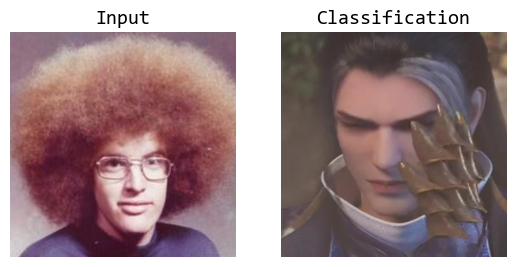

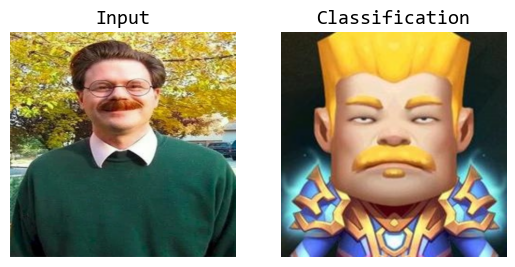

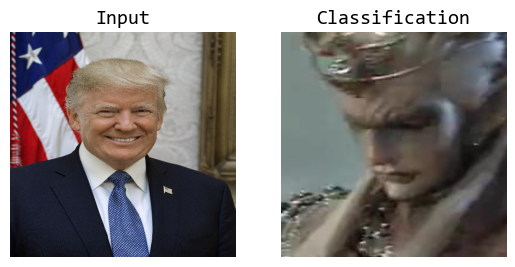

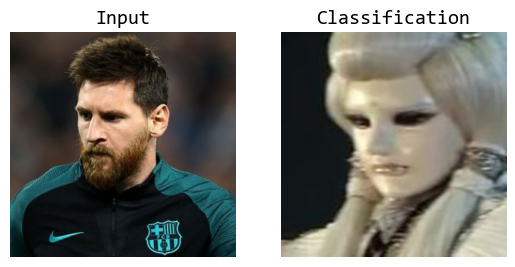

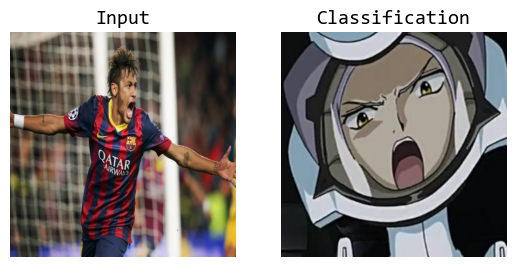

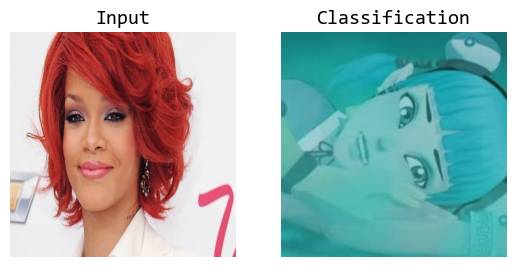

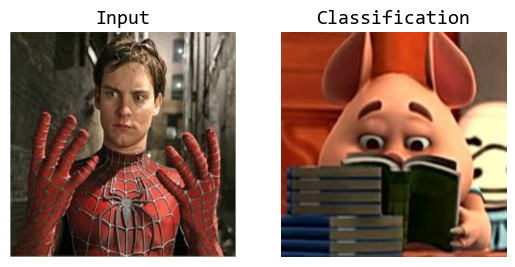

In [55]:
# Load input images
# Feed input images to cartoon character matcher and display results

input_dir = "./input"
input_files = os.listdir(input_dir)

imgs = [None for _ in range(len(input_files))] 

for i, file_name in enumerate(input_files):
    file_dir = os.path.join(input_dir, file_name)
    imgs[i] = cv2.imread(file_dir)

for index in range(len(input_files)):
    img = imgs[index]
    
    # Convert rgb image to grayscale. Gives weights to RGB channels to take human perception of brightness into account
    b, g, r = cv2.split(img)
    img_gray = cv2.convertScaleAbs(0.299 * r + 0.587 * g + 0.114 * b)

    # Extract facial feature
    faces = face_detector.detectMultiScale(img_gray, scaleFactor = 1.1, minNeighbors = 8, minSize = [64, 64])

    if len(faces) == 1:        
        
        for (x, y, h, w) in faces:
            face = img_gray[y: y + h, x: x + w]
            face = cv2.resize(face, (64, 64))
            input_face = np.expand_dims(face.astype(float) / 255.0, axis=0)

            predictions = model.predict(input_face)
            pred_indices = np.argsort(predictions[0])[::-1][:1]

            char_imgs = []

            for pred_index in pred_indices:
                pred_label = CARTOON_CHARACTER_NAMES[pred_index]

                char_folder_name = os.listdir(train_dir)[pred_index]
                char_folder_dir = os.path.join(raw_dir, char_folder_name)
                train_folder_dir = os.path.join(train_dir, char_folder_name)

                # Find most similar image in the class for output
                min_mse = 0
                min_mse_index = None
                for index, img_name in enumerate(os.listdir(train_folder_dir)):    
                    img_dir = os.path.join(train_folder_dir, img_name)
                    char_img = cv2.imread(img_dir, cv2.COLOR_BGR2GRAY)
                    mse = np.mean(np.square(face - char_img))
                    if mse < min_mse or index == 0:
                        min_mse = mse
                        min_mse_index = index

                char_img_dir = os.path.join(char_folder_dir, os.listdir(char_folder_dir)[min_mse_index])
                char_img = cv2.resize(cv2.cvtColor(cv2.imread(char_img_dir), cv2.COLOR_BGR2RGB), (550, 550))
                char_imgs.append(char_img)
            
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(cv2.cvtColor(cv2.resize(img, (550, 550)), cv2.COLOR_BGR2RGB))
        ax1.set_title("Input")
        ax1.axis("off")
        ax2.imshow(char_imgs[0])
        ax2.set_title("Classification")
        ax2.axis("off")

    else:

        char_img = np.zeros((550, 550, 3), np.uint8)

        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "No real faces detected" if len(faces) == 0 else "Multiple faces detected"
        text_size, _ = cv2.getTextSize(text, font, 1, 2)
        text_x = (char_img.shape[1] - text_size[0]) // 2
        text_y = (char_img.shape[0] + text_size[1]) // 2

        cv2.putText(char_img, text, (text_x, text_y), font, 1, (255, 255, 255), 2)

    
plt.show()